In [15]:
# Basic scientific python imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
# Spikeinterface imports (could do this cleaner, oh well)
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.exporters as sxp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
import spikeinterface.curation as scur
import mountainsort5 as ms5

# import spikeinterface_gui
# Core python imports
import os
import time
from pathlib import Path
from IPython.display import Audio

In [16]:
## If reading series of intan recordings
# rec_name = '20220431_poke3_230421_155633'
# path_to_folder = os.normpath('C:/Users/lwood39/Documents/VNCMP/2023-05-20/' + rec_name)
path_to_folder = os.path.normpath(r'C:\Users\lwood39\Documents\VNCMP\2023-05-25\poke2_230525_123745')
dircontents = os.listdir(path_to_folder)
file_names = [x for x in dircontents if '.rhd' in x]
recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
recording = si.concatenate_recordings(recording_list)
display(recording)

# rec_name = 'C:/Users/lwood39/Documents/VNCMP/2023-05-25-01/poke2_230525_160704'
# recording = se.IntanRecordingExtractor(rec_name, stream_id='0')
# recording = recording.frame_slice(start_frame=0, end_frame=int(231*30000))

# ## If reading open ephys recording session
# path_to_folder = Path('G:/SponbergLab/Data/Leo_2023-03-29_15-03-40/Record Node 103/experiment1')
# # path_to_folder = Path('G:/VNCMP/20230308/2023-03-08_13-08-30/Record Node 104')
# recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
# recording = si.SelectSegmentRecording(recording, 0)

ConcatenateSegmentRecording: 32 channels - 30.0kHz - 1 segments - 18,002,688 samples 
                             600.09s (10.00 minutes) - uint16 dtype - 1.07 GiB

In [17]:
# Extract ADC channels, find times where camera trigger was pushed
ADC_recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    ADC_recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='3'))
ADC_recording = si.concatenate_recordings(ADC_recording_list)

trig = ADC_recording.get_traces(start_frame=0, end_frame=36000000, 
                                      return_scaled=True, 
                                      channel_ids=['35']) 
# In some recordings channel 35 is trigger, others 38
trig = trig > 3e6
np.where(np.logical_not(np.equal(np.roll(trig, 1), trig)))[0] / 30000

array([], dtype=float64)

In [18]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

<IPython.core.display.Javascript object>


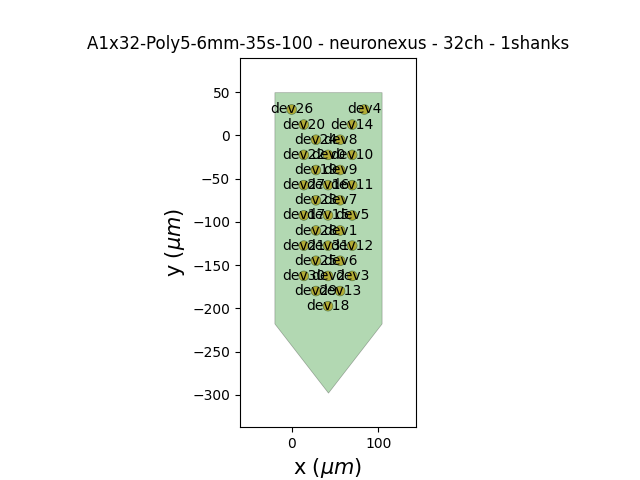

ConcatenateSegmentRecording: 32 channels - 30.0kHz - 1 segments - 18,002,688 samples 
                             600.09s (10.00 minutes) - uint16 dtype - 1.07 GiB

In [19]:
probe = pi.read_probeinterface('A32_A1x32-Poly5-6mm-35s-100.json')
# probe = pi.read_probeinterface('CM32_A1x32-Poly5-6mm-35s-100.json')
pi.plotting.plot_probe(probe.probes[0], with_contact_id=True, with_device_index=True, show_channel_on_click=True)
# recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)

In [20]:
recording = recording.frame_slice(start_frame=int(34*30000), end_frame=int(144*30000))

<IPython.core.display.Javascript object>


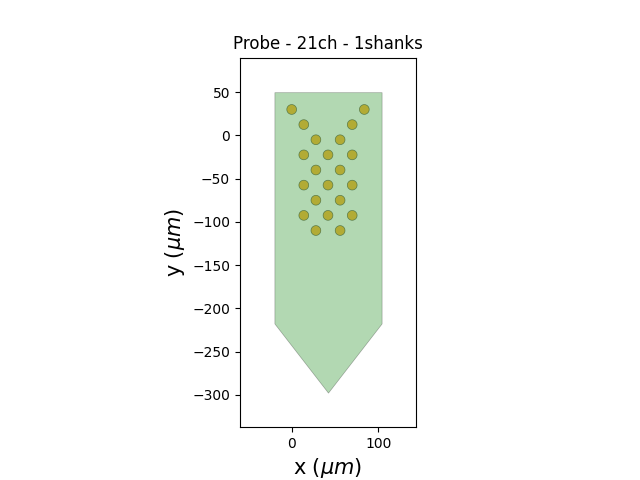

(<matplotlib.collections.PolyCollection at 0x16bc3be1f90>,
 <matplotlib.collections.PolyCollection at 0x16c61885150>)

In [21]:
remove_channels = ['18', '29', '13', '30', '2', '3', '25', '6', '21', '31', '12']
recording = recording.channel_slice(channel_ids=[x for x in recording.get_channel_ids() if x not in remove_channels])
pi.plotting.plot_probe(recording.get_probe())

In [22]:
recording_filter = spre.bandpass_filter(recording, freq_min=300, freq_max=5000)
recording_zscore = spre.zscore(recording_filter, mode='mean+std')
recording_cache_preprocessed = recording_zscore.save(format='binary', n_jobs=8, chunk_duration='10s')

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpwcvun1mx\F4YLXR0V
write_binary_recording with n_jobs = 8 and chunk_size = 300000


write_binary_recording:   0%|          | 0/11 [00:00<?, ?it/s]

In [23]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

## Run Sorter

In [24]:
sorter = 'mountainsort5'
print(ss.get_default_sorter_params(sorter))
ss.get_sorter_params_description(sorter)

{'scheme': '2', 'detect_threshold': 5.5, 'detect_sign': -1, 'detect_time_radius_msec': 0.5, 'snippet_T1': 20, 'snippet_T2': 20, 'npca_per_channel': 3, 'npca_per_subdivision': 10, 'snippet_mask_radius': 250, 'scheme1_detect_channel_radius': 150, 'scheme2_phase1_detect_channel_radius': 200, 'scheme2_detect_channel_radius': 50, 'scheme2_max_num_snippets_per_training_batch': 200, 'scheme2_training_duration_sec': 300, 'scheme2_training_recording_sampling_mode': 'uniform', 'scheme3_block_duration_sec': 1800, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True}


{'scheme': "Which sorting scheme to use: '1, '2', or '3'",
 'detect_threshold': 'Detection threshold - recommend to use the default',
 'detect_sign': 'Use -1 for detecting negative peaks, 1 for positive, 0 for both',
 'detect_time_radius_msec': 'Determines the minimum allowable time interval between detected spikes in the same spatial region',
 'snippet_T1': 'Number of samples before the peak to include in the snippet',
 'snippet_T2': 'Number of samples after the peak to include in the snippet',
 'npca_per_channel': 'Number of PCA features per channel in the initial dimension reduction step',
 'npca_per_subdivision': 'Number of PCA features to compute at each stage of clustering in the isosplit6 subdivision method',
 'snippet_mask_radius': 'Radius of the mask to apply to the extracted snippets',
 'scheme1_detect_channel_radius': 'Channel radius for excluding events that are too close in time in scheme 1',
 'scheme2_phase1_detect_channel_radius': 'Channel radius for excluding events tha

In [ ]:
timer = time.time()
# ms5_params = ms5.Scheme3SortingParameters(
#     block_sorting_parameters=ms5.Scheme2SortingParameters()
#     block_duration_sec=200
# )
ms5_params = ms5.Scheme2SortingParameters(
    detect_sign=1,
    detect_threshold=2.5,
    phase1_detect_time_radius_msec=0.7,
    phase1_detect_channel_radius=None,
    detect_time_radius_msec=0.5,
    detect_channel_radius=None,
    phase1_npca_per_channel=3,
    phase1_npca_per_subdivision=25,
    snippet_T1=40,
    snippet_T2=40,
    snippet_mask_radius=40,
    training_duration_sec=int(0.6 * recording.get_duration()),
    max_num_snippets_per_training_batch=20000)
sort = ms5.sorting_scheme2(
    recording=recording_cache_preprocessed,
    sorting_parameters=ms5_params
)
assert isinstance(sort, si.BaseSorting)
elapsed_sec = time.time() - timer
duration_sec = recording.get_total_duration()
print(sort)
print(f'Elapsed time for sorting: {elapsed_sec:.2f} sec') 
print(f'x{(duration_sec / elapsed_sec):.2f} speed compared with real time for {recording.get_num_channels()} channels')

# Sorting object comes out as NumpySorting, which sits in RAM. Have to move to disk to export to phy
sort_file_path = './most_recent_sort.npz'
se.NpzSortingExtractor.write_sorting(sort, sort_file_path)
time.sleep(1)
Audio('notification-sound.wav', autoplay=True)

Using training recording of duration 66 sec with the sampling mode initial
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.001 seconds ***
Running phase 1 sorting
Number of channels: 21
Number of timepoints: 1980000
Sampling frequency: 30000.0 Hz
Channel 0: [ 42.  -22.5]
Channel 1: [  56. -110.]
Channel 2: [84. 30.]
Channel 3: [ 70.  -92.5]
Channel 4: [ 56. -75.]
Channel 5: [56. -5.]
Channel 6: [ 56. -40.]
Channel 7: [ 70.  -22.5]
Channel 8: [ 70.  -57.5]
Channel 9: [70.  12.5]
Channel 10: [ 42.  -92.5]
Channel 11: [ 42.  -57.5]
Channel 12: [ 14.  -92.5]
Channel 13: [ 28. -40.]
Channel 14: [14.  12.5]
Channel 15: [ 14.  -22.5]
Channel 16: [ 28. -75.]
Channel 17: [28. -5.]
Channel 18: [ 0. 30.]
Channel 19: [ 14.  -57.5]
Channel 20: [  28. -110.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [0,

## Extract, save to Phy GUI

In [26]:
job_kwargs = dict(n_jobs=8, chunk_duration="100s", progress_bar=True)

wave_extract = si.extract_waveforms(
    recording_cache_preprocessed,
    se.NpzSortingExtractor(sort_file_path),
    './waveforms',
    ms_before=1, ms_after=1,
    max_spikes_per_unit=100000,
    overwrite=True, 
    **job_kwargs)

phy_save_path = os.path.join(os.path.dirname(path_to_folder), 'phy_folder',  os.path.basename(path_to_folder) + '_34-144seconds')
sxp.export_to_phy(wave_extract, 
                  phy_save_path, 
                  remove_if_exists=True,
                  **job_kwargs)

with open(phy_save_path + '/params_log.txt', 'w') as f:
    for key, value in ms5_params.__dict__.items():
        if key == 'block_sorting_parameters':
            for subkey, subvalue in value.__dict__.items():
                f.write('%s:%s\n' % (subkey, subvalue))
        else:
            f.write('%s:%s\n' % (key, value))
        

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

write_binary_recording with n_jobs = 8 and chunk_size = 3000000


write_binary_recording:   0%|          | 0/2 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/8 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/8 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/2 [00:00<?, ?it/s]

Run:
phy template-gui  C:\Users\lwood39\Documents\VNCMP\2023-05-25\phy_folder\poke2_230525_123745_34-144seconds\params.py


 To run Phy, use cmd or Powershell, and do one of the following:
 
 1. Run the command spit out by the cell above, often something like:
 
 ```phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\mountainsort5_poke1_230520_153135\params.py```
 
 
 2. Navigate to phy_folder created by the above cell, then run phy command
 
 Example:
 
 ```cd C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort```
 
 ```phy template-gui params.py```
 

## Plot sandbox

<IPython.core.display.Javascript object>


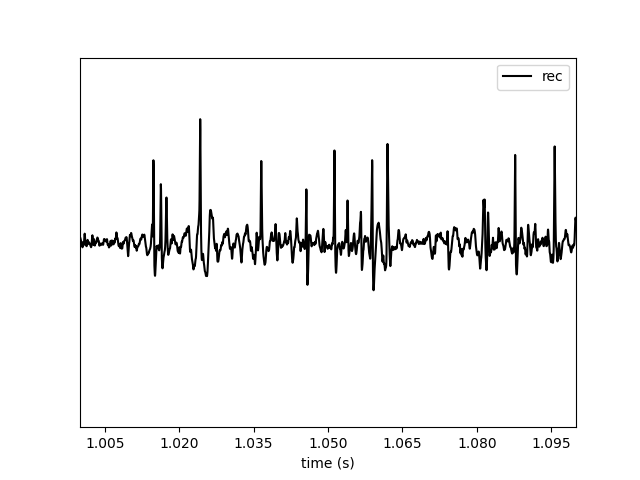

<IPython.core.display.Javascript object>


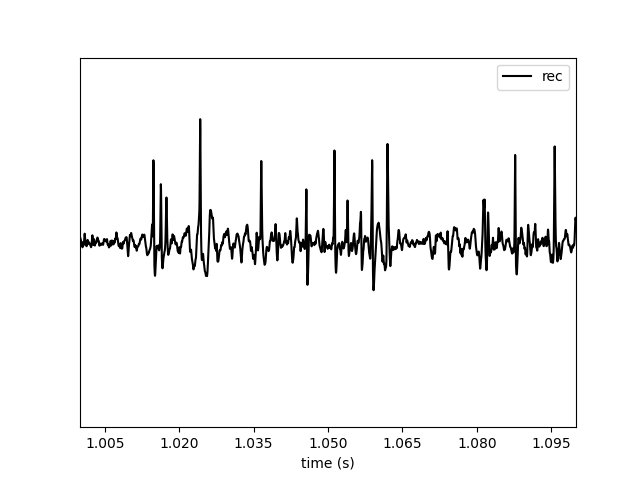

In [69]:
sw.plot_timeseries(recording_cache_filter, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
sw.plot_timeseries(recording_cache_preprocessed, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
plt.show()

<IPython.core.display.Javascript object>


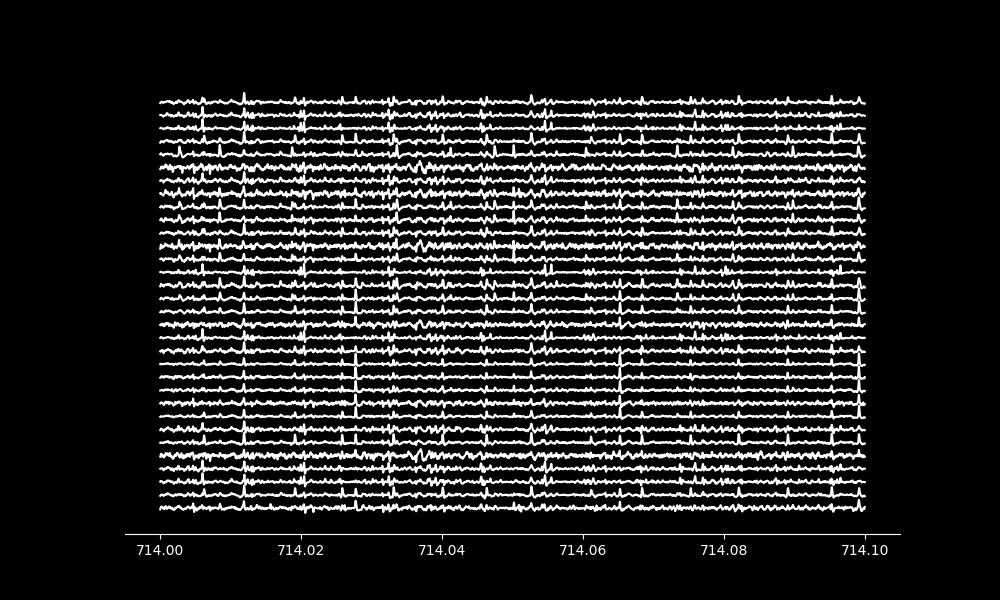

[]

In [127]:
data = recording_cache_preprocessed.get_traces(start_frame=714*30000, end_frame=int(714.15*30000), return_scaled=True, channel_ids=[str(i) for i in range(32)])
x = np.linspace(714, 714.1, data.shape[0])

plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
ax = plt.gca()
for i in range(32):
    ydat = data[:,i] / (np.max(data[:,i]) - np.min(data[:,i]))
    plt.plot(x, ydat + i, 'w')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_yaxis().set_ticks([])

<IPython.core.display.Javascript object>


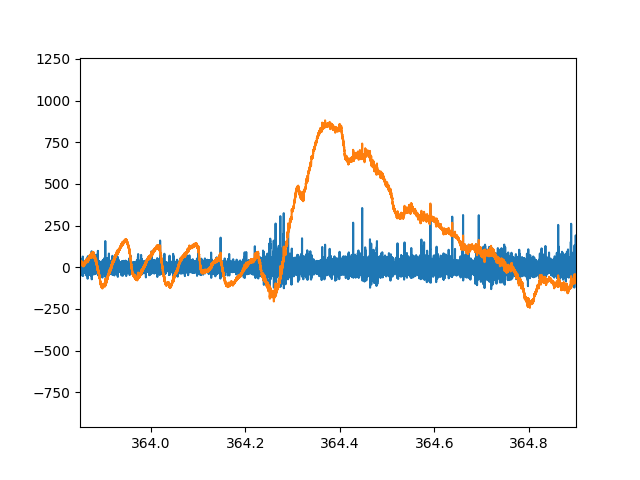

In [56]:
times = (300, 400)
data = recording_cache_justfilter.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
rawdata = recording_cache_raw.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)
plt.figure()
plt.plot(time, data)
plt.xlim((363.85, 364.9))
# plt.show()

# plt.figure()
plt.plot(time, rawdata/5)
plt.xlim((363.85, 364.9))
plt.show()